In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("riplorenzo_clean.csv")

In [2]:
df.head()

,text,from
0,?,Martin
1,Volevo fa na prova,Giuseppe Perrotta
2,Se cambia il nome utente,Giuseppe Perrotta
3,sono sempre io,Martin
4,maurizio valitutto,Martin


In [3]:
df = df[df["text"].notnull()]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71594 entries, 0 to 71593
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    71594 non-null  object
 1   from    71594 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [5]:
df.describe()

,text,from
count,71594,71594
unique,59753,5
top,Hahaha,Giuseppe Perrotta
freq,423,33091


In [6]:
df.isnull().sum()

text    0
from    0
dtype: int64

In [7]:
df = df.dropna()
df.isnull().sum()

text    0
from    0
dtype: int64

In [8]:
df['from'].value_counts()

Giuseppe Perrotta        33091
Ambrogio Delle Chiaie    18857
Martin                    8968
Ciro Vitiello             5435
Lorenzo Valitutto         5243
Name: from, dtype: int64

In [9]:
df["textlen"] = df["text"].apply(lambda x: len(x))

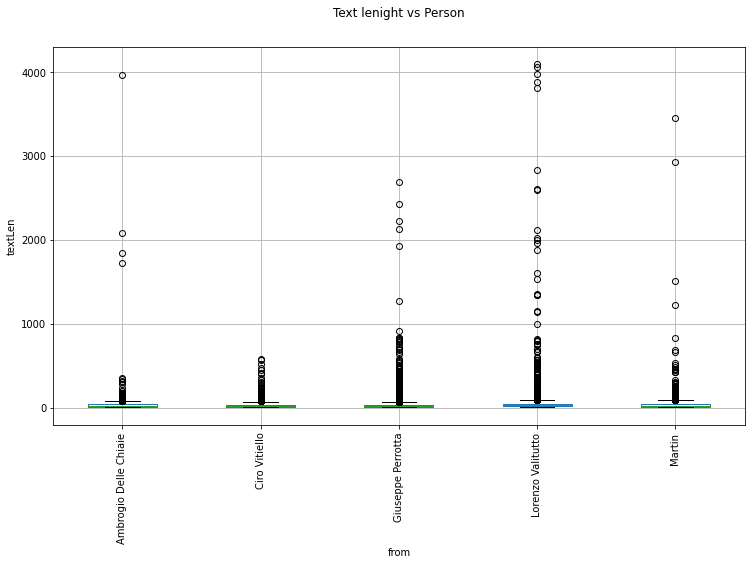

In [10]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
df.boxplot('textlen', 'from', ax=ax)
plt.suptitle('Text lenight vs Person')
plt.title('')
plt.ylabel('textLen')
plt.xticks(rotation=90)
plt.show()

In [11]:
df = df[df["textlen"] <= 1000]
df = df[df["textlen"] >= 10]

In [12]:
df['from'].value_counts()

Giuseppe Perrotta        27187
Ambrogio Delle Chiaie    15487
Martin                    6852
Lorenzo Valitutto         4301
Ciro Vitiello             4189
Name: from, dtype: int64

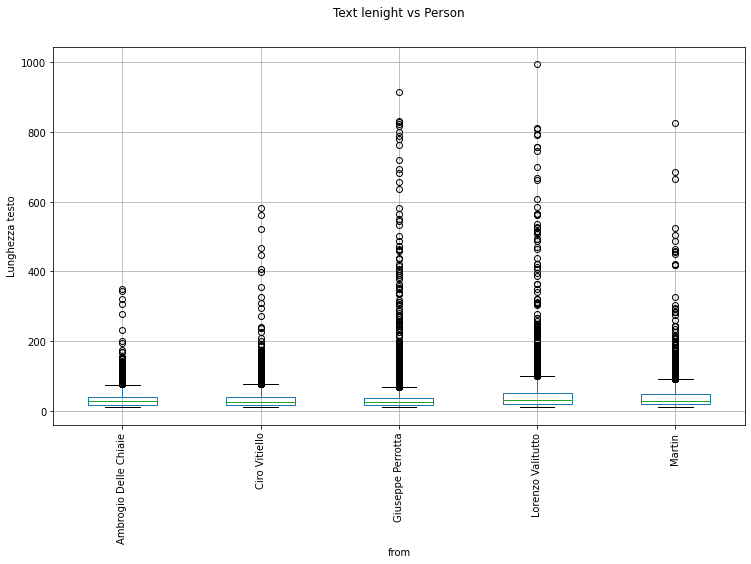

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
df.boxplot('textlen', 'from', ax=ax)
plt.suptitle('Text lenight vs Person')
plt.title('')
plt.ylabel('Lunghezza testo')
plt.xticks(rotation=90)
plt.show()
fig.savefig('foo.png')

In [14]:
random_state = 420
nsamples = 4500
df_peppe = df[df["from"] == "Giuseppe Perrotta"].sample(nsamples, random_state=random_state)
df_ambrogio = df[df["from"] == "Ambrogio Delle Chiaie"].sample(nsamples, random_state=random_state)
df_martin = df[df["from"] == "Martin"].sample(nsamples, random_state=random_state)



In [15]:
df = pd.concat([df_peppe, df_martin, df_ambrogio, df[df["from"] == "Ciro Vitiello"], df[df["from"] == "Lorenzo Valitutto"]])

In [37]:
df['from'].value_counts()

Giuseppe Perrotta        4500
Martin                   4500
Ambrogio Delle Chiaie    4500
Lorenzo Valitutto        4301
Ciro Vitiello            4189
Name: from, dtype: int64

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['from_enc'] = le.fit_transform(df['from'])
#le.classes_
df['from_enc'].unique()

array([2, 4, 0, 1, 3])

In [22]:
X = df.drop(["from", "textlen", "from_enc"], axis=1)
y = df["from_enc"]

In [23]:
#Hyperparameters

#Logistics Regression
logreg_C = 1.0

#SVM
SVC_C = 1.0

#XGBoost
xgb_max_depth = 7
xgb_n_estimators = 200
xgb_colsample_bytree = 0.8
xgb_subsample = 0.8
xgb_nthread = 10
xgb_learning_rate = 0.1

# Neural net hyperparameters
NUMBER_OF_CLASSES = len(set(y))
NUMBER_OF_EPOCHS = 5
activation = "relu"
dropout = 0.2
recurrent_dropout = 0.3
batch_size = 64
layer_size = 300
optimizer = 'adam'

In [24]:
it_stopwords_file = open("stopwords-it.txt", "r", encoding="UTF-8")
data = it_stopwords_file.read()
stopwords_it = data.replace('\n', ' ').split(" ") 
it_stopwords_file.close()

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
ctv_analyzer = "word"
ctv_ngram_range = (1, 3)
ctv_stopwords = stopwords_it
ctv = CountVectorizer(analyzer=ctv_analyzer,token_pattern=r'\w{1,}',
            ngram_range=ctv_ngram_range, stop_words=ctv_stopwords)

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(X["text"]))
xtrain_ctv =  ctv.transform(X["text"])

In [26]:
from sklearn.linear_model import LogisticRegression
models = [
    ("Logistics Regression", LogisticRegression(C=logreg_C))
]


feature_sets = {
    "CTV" : {
        "train": xtrain_ctv,
    }
}

In [27]:
from sklearn import metrics
import tensorflow as tf
#funzione per stampare metriche modelli tramite metrics di sklearn
def sklearn_metrics(clf, xvalid, yvalid, clf_name="", featureset_name=""):
    predictions_prob = clf.predict_proba(xvalid)
    predictions = clf.predict(xvalid)

    print(f"logloss: {metrics.log_loss(yvalid, predictions_prob)}")
    print("Report:")
    print(metrics.classification_report(yvalid,predictions))
    accuracy = metrics.accuracy_score(yvalid, predictions)
    cm = metrics.confusion_matrix(yvalid, predictions)
    disp = metrics.ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    disp.plot()
    disp.ax_.set_title(f"{clf_name}\nFeatures: {featureset_name}\nAccuracy: {accuracy}")

In [28]:

model_name = models[0][0]
model = models[0][1]
print("----"*40)
print(f"* Training: {model_name}")
print("___"*20)
print(f"\t***** Using feature set: {feature_sets['CTV']}")
model.fit(feature_sets['CTV']["train"], y)

----------------------------------------------------------------------------------------------------------------------------------------------------------------
* Training: Logistics Regression
____________________________________________________________
	***** Using feature set: {'train': <21990x79904 sparse matrix of type '<class 'numpy.int64'>'
	with 133893 stored elements in Compressed Sparse Row format>}


c:\Users\simon\PycharmProjects\ml-app-salaryprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

logloss: 0.6108331110951649
Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4500
           1       0.89      0.87      0.88      4189
           2       0.81      0.90      0.85      4500
           3       0.90      0.88      0.89      4301
           4       0.95      0.89      0.92      4500

    accuracy                           0.89     21990
   macro avg       0.89      0.89      0.89     21990
weighted avg       0.89      0.89      0.89     21990



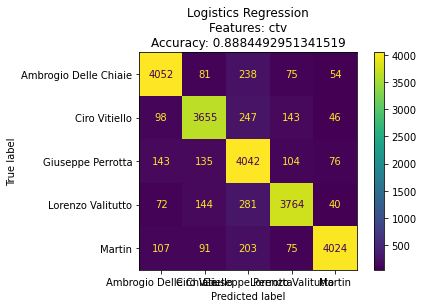

In [29]:
sklearn_metrics(model, feature_sets['CTV']["train"], y, clf_name=model_name, featureset_name="ctv")

In [30]:
# country, edlevel, yearscode
X = "Ciao ragazzi come state?"
X

'Ciao ragazzi come state?'

In [31]:
X = ctv.transform([X])

In [32]:
y_pred = model.predict(X)
le.inverse_transform([2])

array(['Giuseppe Perrotta'], dtype=object)

In [33]:
import pickle

In [35]:
data = {"model": model, "le": le, "ctv": ctv}
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(data, file)

In [36]:
with open('saved_steps.pkl', 'rb') as file:
    data = pickle.load(file)

model_loaded = data["model"]
le = data["le"]
ctv = data["ctv"]

In [37]:
y_pred = model_loaded.predict(X)
y_pred

array([2])